In [233]:
### connect to the database
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
con = sqlite3.connect('atliq_db.sqlite3') #-->specify the path to your 
#downloaded database just like you read csv files

### check all tables in the database
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

### execute simple query in Python with your connection
query="""Select * from 
dim_customer
LIMIT 10
"""
dim_customer=pd.read_sql_query(query, con)
dim_customer.head()

[('dim_customer',), ('dim_product',), ('fact_pre_discount',), ('fact_manufacturing_cost',), ('fact_gross_price',), ('fact_sales_monthly',)]


,customer_code,customer,platform,channel,market,sub_zone,region
0,70002017,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
1,70002018,Atliq e Store,E-Commerce,Direct,India,India,APAC
2,70003181,Atliq Exclusive,Brick & Mortar,Direct,Indonesia,ROA,APAC
3,70003182,Atliq e Store,E-Commerce,Direct,Indonesia,ROA,APAC
4,70004069,Atliq Exclusive,Brick & Mortar,Direct,Japan,ROA,APAC


In [234]:
#Test if libraries can be access
#con = sqlite3.connect('atliq_db.sqlite3')
#query = "SELECT * FROM dim_product"
#dim_product = pd.read_sql_query(query, con)
#dim_product.head(5)

In [235]:
# Read all the libraries and assign them to names
dim_customer = pd.read_sql_query(query, con)
dim_product = pd.read_sql_query(query, con)
fact_pre_discount = pd.read_sql_query(query, con)
fact_manufacturing_cost = pd.read_sql_query(query, con)
fact_gross_price = pd.read_sql_query(query, con)
fact_sales_monthly = pd.read_sql_query(query, con)

In [236]:
# Connect to the database
con = sqlite3.connect('atliq_db.sqlite3')

# SQL query to select all columns from the dim_product table
query = "SELECT * FROM fact_manufacturing_cost"

# Execute the query and load the result into a DataFrame
fact_manufacturing_cost = pd.read_sql_query(query, con)

# Display the DataFrame
display(fact_manufacturing_cost.head(5))

# Close the database connection
con.close()

,product_code,cost_year,manufacturing_cost
0,A0118150101,2018,4.6190
1,A0118150101,2019,4.2033
2,A0118150101,2020,5.0207
3,A0118150101,2021,5.5172
4,A0118150102,2018,5.6036


# 1. Quantity Top sellers

We will gather the top sellers for the month and quarter to see which products were selling the most during times of the year.

In [237]:
con = sqlite3.connect('atliq_db.sqlite3')

# Load the datasets into DataFrames
dim_customer = pd.read_sql_query("SELECT * FROM dim_customer", con)
dim_product = pd.read_sql_query("SELECT * FROM dim_product", con)
fact_pre_discount = pd.read_sql_query("SELECT * FROM fact_pre_discount", con)
fact_manufacturing_cost = pd.read_sql_query("SELECT * FROM fact_manufacturing_cost", con)
fact_gross_price = pd.read_sql_query("SELECT * FROM fact_gross_price", con)
fact_sales_monthly = pd.read_sql_query("SELECT * FROM fact_sales_monthly", con)

# Close the database connection
con.close()

In [238]:
# Merge fact_sales_monthly with dim_product to get product names
merged_data = pd.merge(fact_sales_monthly, dim_product, how='left', left_on='product_code', right_on='product_code')

In [239]:
# Convert 'date' column to datetime
merged_data['date'] = pd.to_datetime(merged_data['date'])

In [240]:
# Extract month and year from the date
merged_data['month_year'] = merged_data['date'].dt.to_period('M')

In [241]:
# Aggregate sales data
monthly_sales = merged_data.groupby(['month_year', 'product'])['sold_quantity'].sum().reset_index()

In [242]:
# Rank the products by sales within each month
monthly_sales['rank'] = monthly_sales.groupby('month_year')['sold_quantity'].rank(method='first', ascending=False)

In [243]:
# Select the top 3 products for each month
top2_monthly_sales = monthly_sales[monthly_sales['rank'] <= 2].sort_values(['month_year', 'rank'])

In [244]:
# Convert month_year to string for better visualization
top2_monthly_sales['month_year'] = top2_monthly_sales['month_year'].astype(str)

In [245]:
# Display the results
display(top2_monthly_sales.head(8))

,month_year,product,sold_quantity,rank
1,2017-09,AQ Mforce Gen X,6188.0,1.0
0,2017-09,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,5237.0,2.0
3,2017-10,AQ Mforce Gen X,8388.0,1.0
2,2017-10,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,6472.0,2.0
5,2017-11,AQ Mforce Gen X,11370.0,1.0
4,2017-11,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,9642.0,2.0
7,2017-12,AQ Mforce Gen X,12043.0,1.0
6,2017-12,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,9572.0,2.0


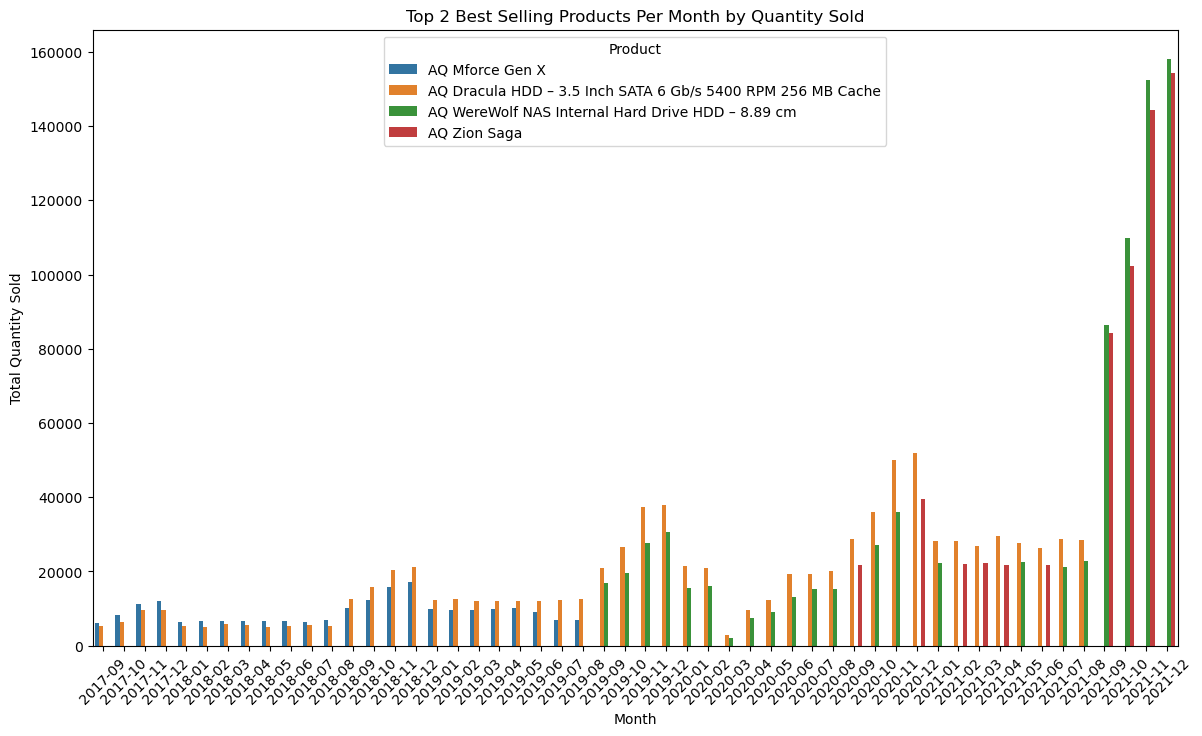

In [246]:
#Create a plot graph to show case how they are always the top sellers
plt.figure(figsize=(14, 8))
sns.barplot(x='month_year', y='sold_quantity', hue='product', data=top2_monthly_sales)
plt.title('Top 2 Best Selling Products Per Month by Quantity Sold')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.legend(title='Product')
plt.xticks(rotation=45)
plt.show()

At the beginning of our graph in September of 2017, the "Mforce Gen X" and "Dracula HDD" were the top sellers for a long time until July 2017. After this, the Mforce was replace with "WereWolf NAS HHD". On the other hand, the Dracula HDD was a top seller until July 2021. Three years of being a top seller says something about a product. In august of 2021 Not only sales skyrocketed with the "WereWolf NAS HDD" and "Zion Saga" being the top sellers.

Top Sellers per Quarter

In [247]:
# Merge fact_sales_monthly with dim_product to get product names
merged_data = pd.merge(fact_sales_monthly, dim_product, how='left', left_on='product_code', right_on='product_code')

In [248]:
# Convert 'date' column to datetime if necessary
merged_data['date'] = pd.to_datetime(merged_data['date'])

In [249]:
# Extract year and quarter from the date
merged_data['year'] = merged_data['date'].dt.year
merged_data['quarter'] = merged_data['date'].dt.quarter
merged_data['year_quarter'] = merged_data['year'].astype(str) + '-Q' + merged_data['quarter'].astype(str)

In [250]:
# Aggregate sales data
quarterly_sales = merged_data.groupby(['year_quarter', 'product'])['sold_quantity'].sum().reset_index()

In [251]:
# Rank the products by sales within each quarter
quarterly_sales['rank'] = quarterly_sales.groupby('year_quarter')['sold_quantity'].rank(method='first', ascending=False)

In [252]:
# Select the top 2 products for each quarter
top2_quarterly_sales = quarterly_sales[quarterly_sales['rank'] <= 2].sort_values(['year_quarter', 'rank'])

In [253]:
# Display the results
display(top2_quarterly_sales.head(6))

,year_quarter,product,sold_quantity,rank
1,2017-Q3,AQ Mforce Gen X,6188.0,1.0
0,2017-Q3,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,5237.0,2.0
3,2017-Q4,AQ Mforce Gen X,31801.0,1.0
2,2017-Q4,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,25686.0,2.0
5,2018-Q1,AQ Mforce Gen X,19856.0,1.0
4,2018-Q1,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,16117.0,2.0


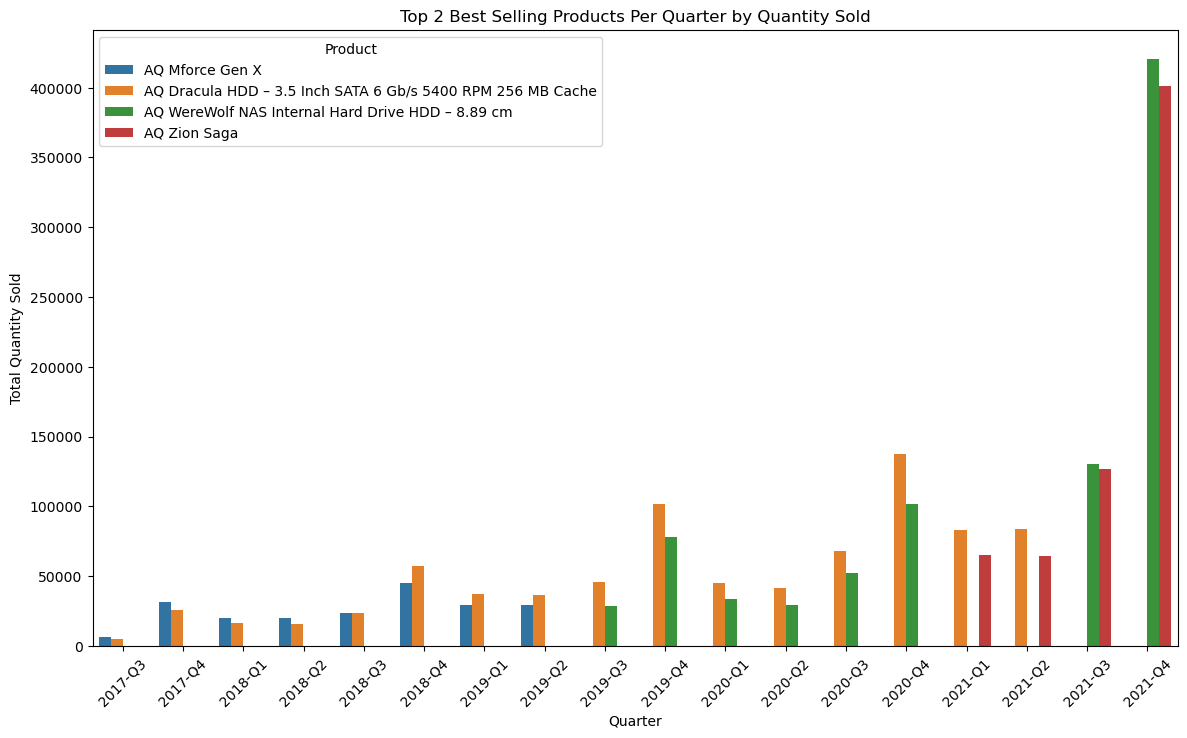

In [254]:
# Plot graph for best sellers per quarter
plt.figure(figsize=(14, 8))
sns.barplot(x='year_quarter', y='sold_quantity', hue='product', data=top2_quarterly_sales)
plt.title('Top 2 Best Selling Products Per Quarter by Quantity Sold')
plt.xlabel('Quarter')
plt.ylabel('Total Quantity Sold')
plt.legend(title='Product')
plt.xticks(rotation=45)
plt.show()

Taking a look at the quarterly, we can see how its very similar to the monthly sales, in regards to the top sellers.

### 2. Revenue Top Sellers

We will gather the revenue for each top seller from the previous mentioned per month and quarter.

In [255]:
# Connect to the database
con = sqlite3.connect('atliq_db.sqlite3')

In [256]:
# Load the datasets into DataFrames
dim_product = pd.read_sql_query("SELECT * FROM dim_product", con)
fact_sales_monthly = pd.read_sql_query("SELECT * FROM fact_sales_monthly", con)
fact_gross_price = pd.read_sql_query("SELECT * FROM fact_gross_price", con)

In [257]:
# Close the database connection
con.close()

In [258]:
# Ensure the date columns are correctly parsed
fact_sales_monthly['date'] = pd.to_datetime(fact_sales_monthly['date'])

In [259]:
# Extract the fiscal year from the date in the sales data
fact_sales_monthly['fiscal_year'] = fact_sales_monthly['date'].dt.year

In [260]:
# Merge fact_sales_monthly with fact_gross_price to get gross price information
merged_sales_price = pd.merge(fact_sales_monthly, fact_gross_price, 
                              how='left', 
                              on=['product_code', 'fiscal_year'])

In [261]:
# Calculate revenue (gross price * sold quantity)
merged_sales_price['revenue'] = merged_sales_price['gross_price'] * merged_sales_price['sold_quantity']

In [262]:
# Merge the result with dim_product to get product names
merged_data = pd.merge(merged_sales_price, dim_product, how='left', left_on='product_code', right_on='product_code')


In [263]:
# Extract month and year from the date
merged_data['month_year'] = merged_data['date'].dt.to_period('M')

In [264]:
# Extract year and quarter from the date
merged_data['year'] = merged_data['date'].dt.year
merged_data['quarter'] = merged_data['date'].dt.quarter
merged_data['year_quarter'] = merged_data['year'].astype(str) + '-Q' + merged_data['quarter'].astype(str)

In [265]:
# Aggregate sales data by month
monthly_sales = merged_data.groupby(['month_year', 'product'])['revenue'].sum().reset_index()

In [266]:
# Rank the products by revenue within each month
monthly_sales['rank'] = monthly_sales.groupby('month_year')['revenue'].rank(method='first', ascending=False)

In [267]:
# Select the top 2 products for each month
top2_monthly_sales = monthly_sales[monthly_sales['rank'] <= 2].sort_values(['month_year', 'rank'])

In [268]:
# Convert month_year to string for better visualization
top2_monthly_sales['month_year'] = top2_monthly_sales['month_year'].astype(str)

In [269]:
# Aggregate sales data by quarter
quarterly_sales = merged_data.groupby(['year_quarter', 'product'])['revenue'].sum().reset_index()

In [270]:
# Rank the products by revenue within each quarter
quarterly_sales['rank'] = quarterly_sales.groupby('year_quarter')['revenue'].rank(method='first', ascending=False)

In [271]:
# Select the top 2 products for each quarter
top2_quarterly_sales = quarterly_sales[quarterly_sales['rank'] <= 2].sort_values(['year_quarter', 'rank'])

In [272]:
# Display the results
display(top2_monthly_sales.sample(4))
display(top2_quarterly_sales.sample(4))

,month_year,product,revenue,rank
42,2019-03,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,211736.6487,1.0
57,2019-08,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,222727.9226,1.0
3,2017-10,AQ Mforce Gen X,0.0000,2.0
34,2018-12,AQ Mforce Gen X,295202.8091,2.0


,year_quarter,product,revenue,rank
8,2018-Q3,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,434157.6716,1.0
30,2020-Q1,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,791789.5538,2.0
20,2019-Q3,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,812256.8192,1.0
14,2019-Q1,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,655357.8758,1.0


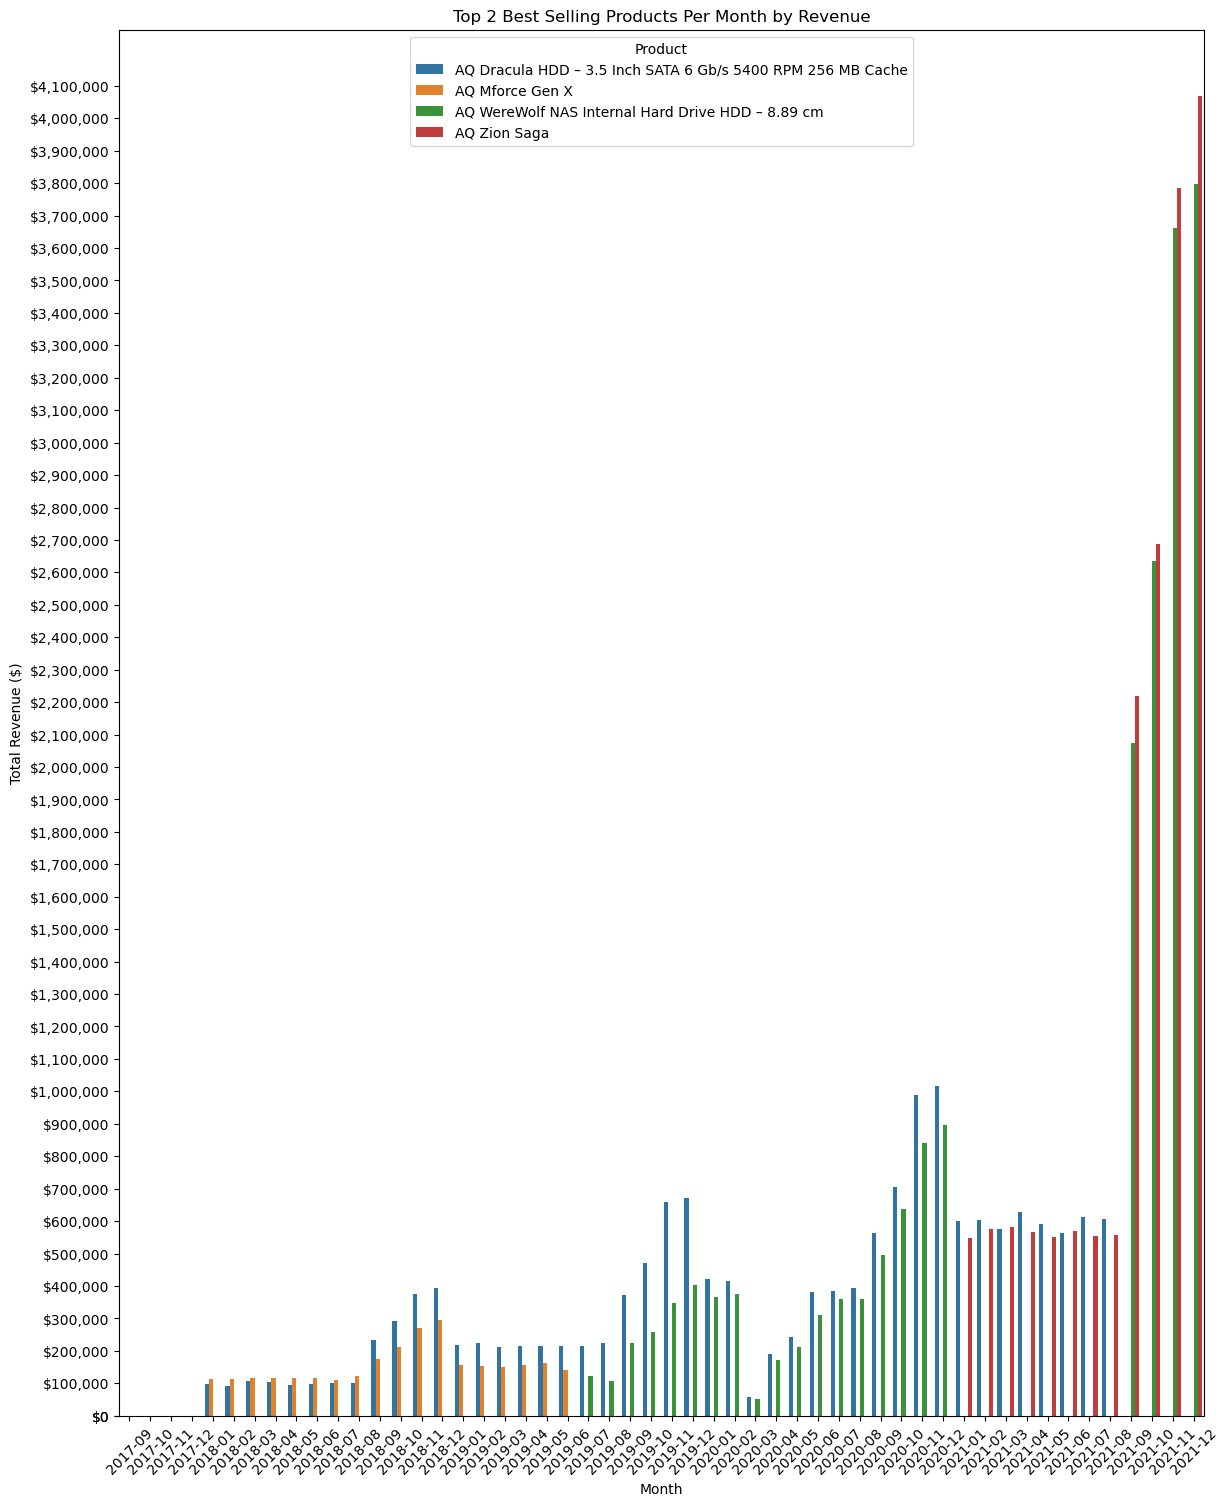

In [273]:
# Plot for monthly top sellers by revenue
plt.figure(figsize=(14, 18))
sns.barplot(x='month_year', y='revenue', hue='product', data=top2_monthly_sales)
plt.title('Top 2 Best Selling Products Per Month by Revenue')
plt.xlabel('Month')
plt.ylabel('Total Revenue ($)')
plt.legend(title='Product')
plt.xticks(rotation=45)

# Custom ticks for Y-axis
max_revenue_first_3_months = top2_monthly_sales[top2_monthly_sales['month_year'].isin(top2_monthly_sales['month_year'].unique()[:3])]['revenue'].max()
ticks_first_3_months = np.arange(0, max_revenue_first_3_months + 10000, 10000)
ticks_rest = np.arange(max_revenue_first_3_months, top2_monthly_sales['revenue'].max() + 100000, 100000)
custom_ticks = np.concatenate([ticks_first_3_months, ticks_rest])
custom_labels = ['${:,.0f}'.format(x) for x in custom_ticks]
plt.yticks(ticks=custom_ticks, labels=custom_labels)

plt.show()

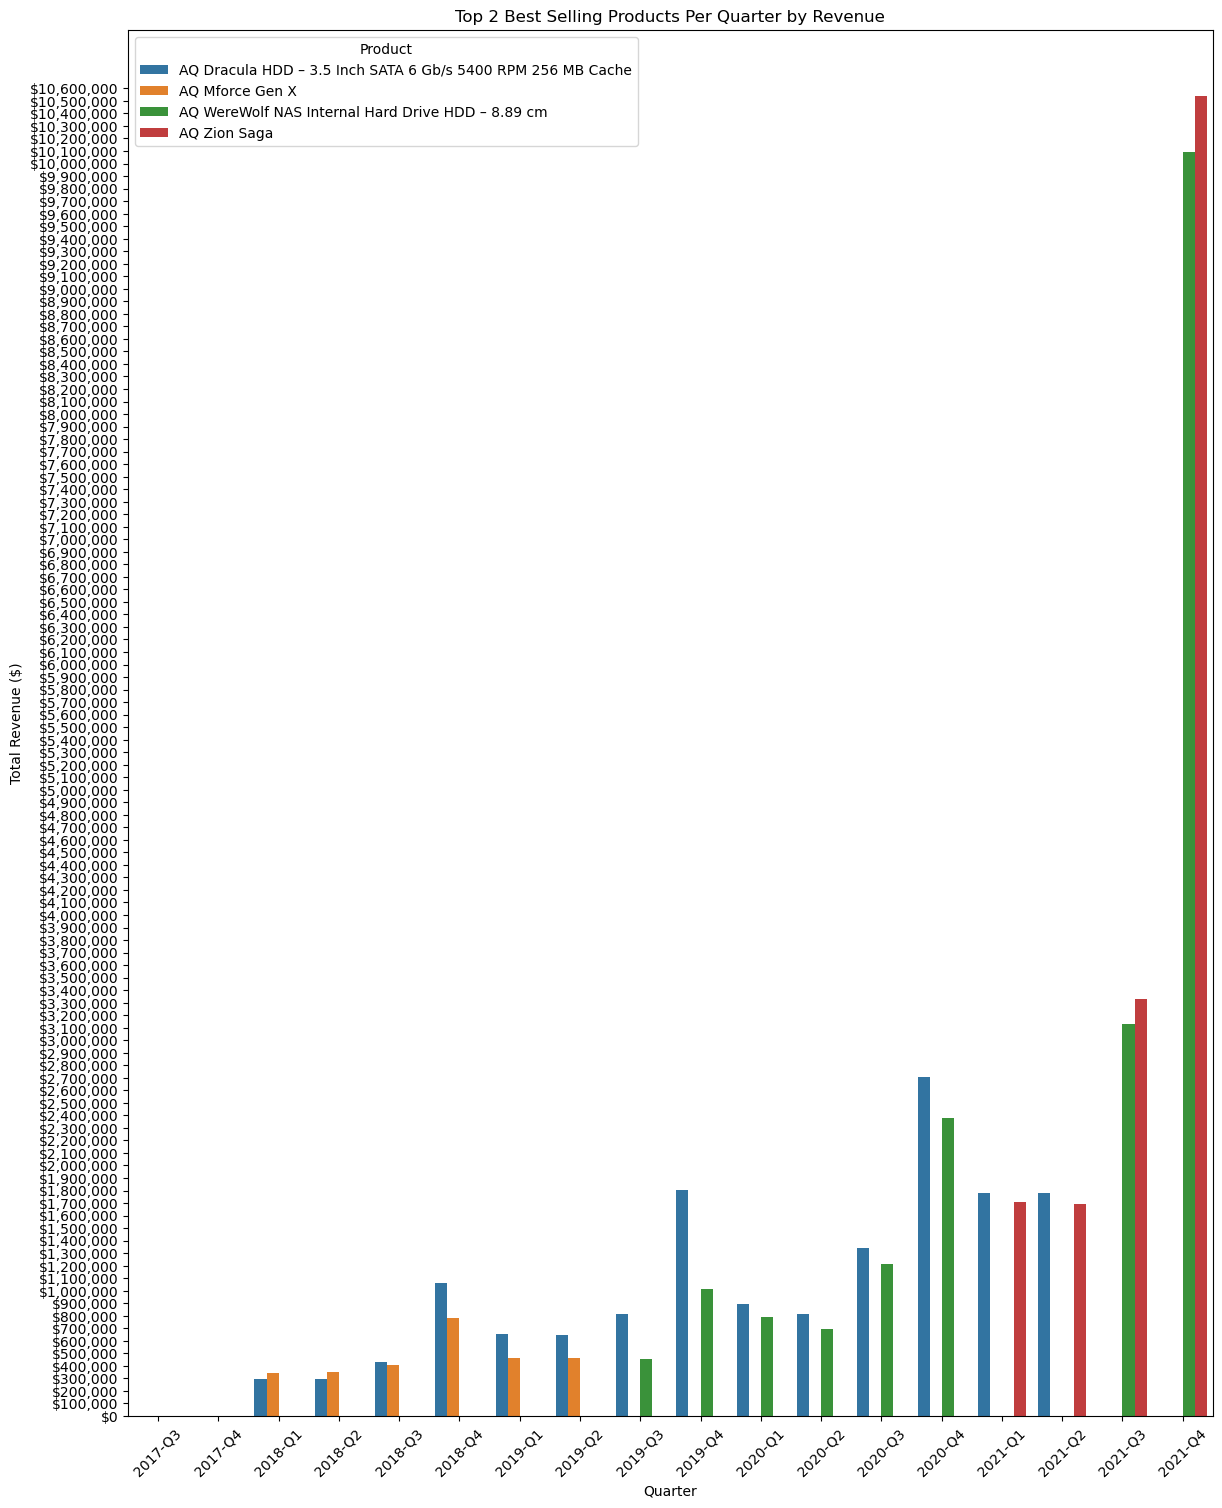

In [274]:
# Plot for quarterly top sellers by revenue
plt.figure(figsize=(14, 18))
sns.barplot(x='year_quarter', y='revenue', hue='product', data=top2_quarterly_sales)
plt.title('Top 2 Best Selling Products Per Quarter by Revenue')
plt.xlabel('Quarter')
plt.ylabel('Total Revenue ($)')
plt.legend(title='Product')
plt.xticks(rotation=45)

# Custom ticks for Y-axis for quarterly data
max_revenue_quarter = top2_quarterly_sales['revenue'].max()
ticks_quarter = np.arange(0, max_revenue_quarter + 100000, 100000)
custom_labels_quarter = ['${:,.0f}'.format(x) for x in ticks_quarter]
plt.yticks(ticks=ticks_quarter, labels=custom_labels_quarter)

plt.show()

The amount of revenue created by the top sellers instant goes up as soon as the 2nd half 2021 comes along. The revenue per month and quarter increases after August. The last quarter being over 10 million in revenue and more specifically over 3 million just in the month of December from the two top sellers.

### Rate of repurchase

In [275]:
# Connect to the database
con = sqlite3.connect('atliq_db.sqlite3')

In [276]:
# Load the datasets into DataFrames
dim_product = pd.read_sql_query("SELECT * FROM dim_product", con)
fact_sales_monthly = pd.read_sql_query("SELECT * FROM fact_sales_monthly", con)
fact_gross_price = pd.read_sql_query("SELECT * FROM fact_gross_price", con)

In [277]:
# Close the database connection
con.close()

In [278]:
# Ensure the date columns are correctly parsed
fact_sales_monthly['date'] = pd.to_datetime(fact_sales_monthly['date'])
fact_sales_monthly['fiscal_year'] = fact_sales_monthly['date'].dt.year

In [279]:
# Merge fact_sales_monthly with fact_gross_price to get gross price information
merged_sales_price = pd.merge(fact_sales_monthly, fact_gross_price, 
                              how='left', 
                              on=['product_code', 'fiscal_year'])

In [280]:
# Calculate revenue (gross price * sold quantity)
merged_sales_price['revenue'] = merged_sales_price['gross_price'] * merged_sales_price['sold_quantity']

In [281]:
# Merge the result with dim_product to get product names
merged_data = pd.merge(merged_sales_price, dim_product, how='left', left_on='product_code', right_on='product_code')

In [282]:
# Extract month and year from the date
merged_data['month_year'] = merged_data['date'].dt.to_period('M')
merged_data['year'] = merged_data['date'].dt.year
merged_data['quarter'] = merged_data['date'].dt.quarter
merged_data['year_quarter'] = merged_data['year'].astype(str) + '-Q' + merged_data['quarter'].astype(str)

In [283]:
# Aggregate sales data by month
monthly_sales = merged_data.groupby(['month_year', 'product', 'customer_code'])['revenue'].sum().reset_index()
monthly_sales['rank'] = monthly_sales.groupby('month_year')['revenue'].rank(method='first', ascending=False)
top2_monthly_sales = monthly_sales[monthly_sales['rank'] <= 2].sort_values(['month_year', 'rank'])

In [284]:
# Identify repurchase events
merged_data.sort_values(by=['customer_code', 'product_code', 'date'], inplace=True)
merged_data['previous_purchase_date'] = merged_data.groupby(['customer_code', 'product_code'])['date'].shift(1)
merged_data['repurchase'] = merged_data.apply(lambda row: 1 if pd.notnull(row['previous_purchase_date']) else 0, axis=1)

In [285]:
# Calculate repurchase rate
repurchase_rate = merged_data.groupby('product_code').agg({
    'repurchase': 'sum',
    'customer_code': 'nunique'
}).reset_index()
repurchase_rate['repurchase_rate'] = repurchase_rate['repurchase'] / repurchase_rate['customer_code']

In [286]:
# Merge with product names
repurchase_rate = repurchase_rate.merge(dim_product[['product_code', 'product']], on='product_code', how='left')

In [287]:
# Filter for top 2 products by revenue
top2_products = top2_monthly_sales['product'].unique()
repurchase_rate_top2 = repurchase_rate[repurchase_rate['product'].isin(top2_products)]

In [290]:
# Display repurchase rates
display(repurchase_rate_top2.head(5))

,product_code,repurchase,customer_code,repurchase_rate,product
1,A0118150101,5796,209,27.732057,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...
2,A0118150102,5794,209,27.722488,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...
3,A0118150103,6426,209,30.746411,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...
4,A0118150104,6434,209,30.784689,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...
5,A0219150201,5536,209,26.488038,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm


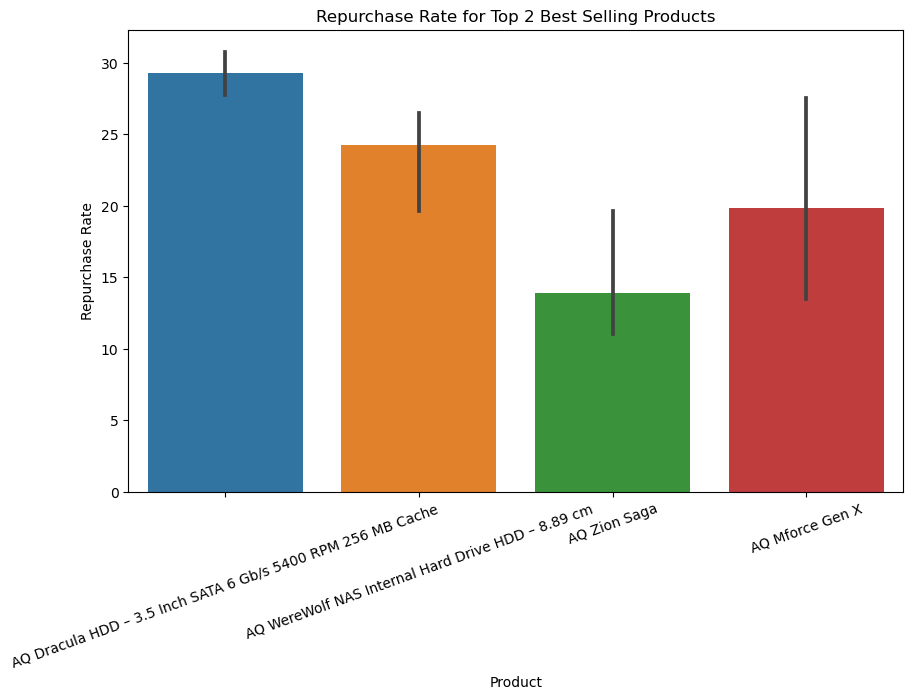

In [292]:
# PLot for repurchase rate
plt.figure(figsize=(10, 6))
sns.barplot(x='product', y='repurchase_rate', data=repurchase_rate_top2)
plt.title('Repurchase Rate for Top 2 Best Selling Products')
plt.xlabel('Product')
plt.ylabel('Repurchase Rate')
plt.xticks(rotation=20)
plt.show()

The repurchase rate its pretty high for each one of the top sellers. "Dracula HDD" with almost 30 being the highest. Followed by "WereWold NAS Internal". We can see that the repurchase rate is pretty high and the reason why they have such a high revenue.

### Products that sell the least

,month_year,product,revenue,rank
0,2017-09,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,0.0,1.0
1,2017-09,AQ Mforce Gen X,0.0,2.0
2,2017-10,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,0.0,1.0
3,2017-10,AQ Mforce Gen X,0.0,2.0


,year_quarter,product,revenue,rank
0,2017-Q3,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,0.0,1.0
1,2017-Q3,AQ Mforce Gen X,0.0,2.0
2,2017-Q4,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,0.0,1.0
3,2017-Q4,AQ Mforce Gen X,0.0,2.0


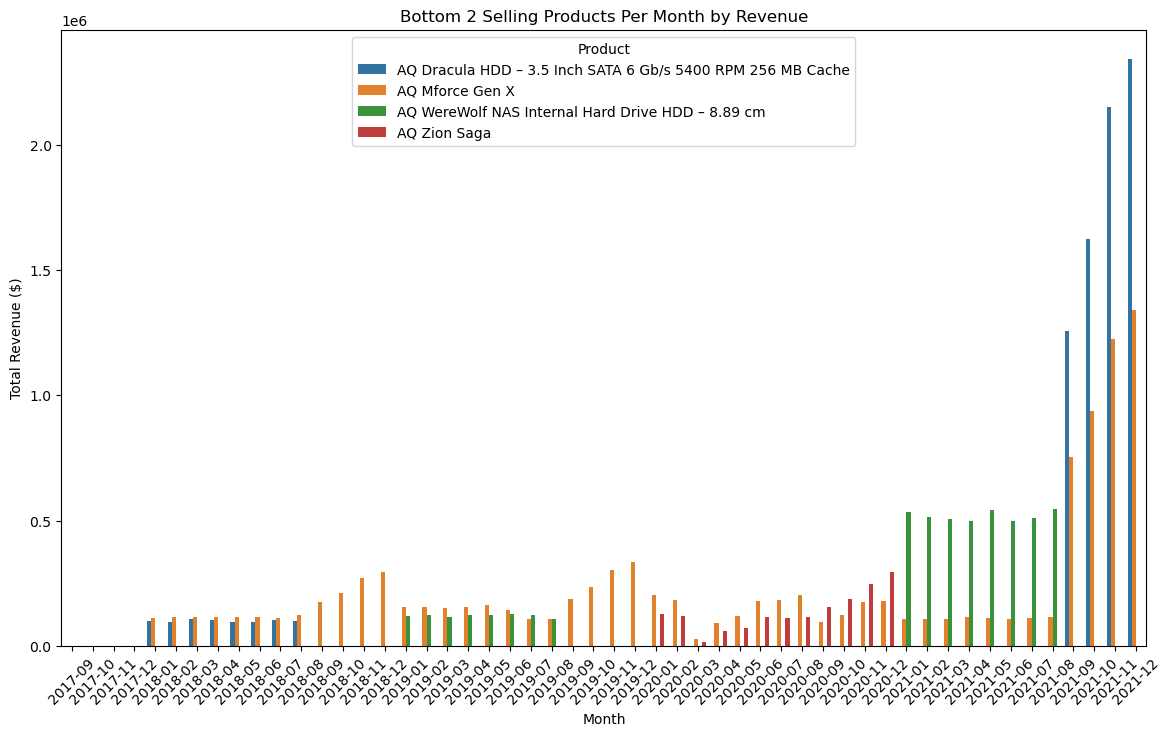

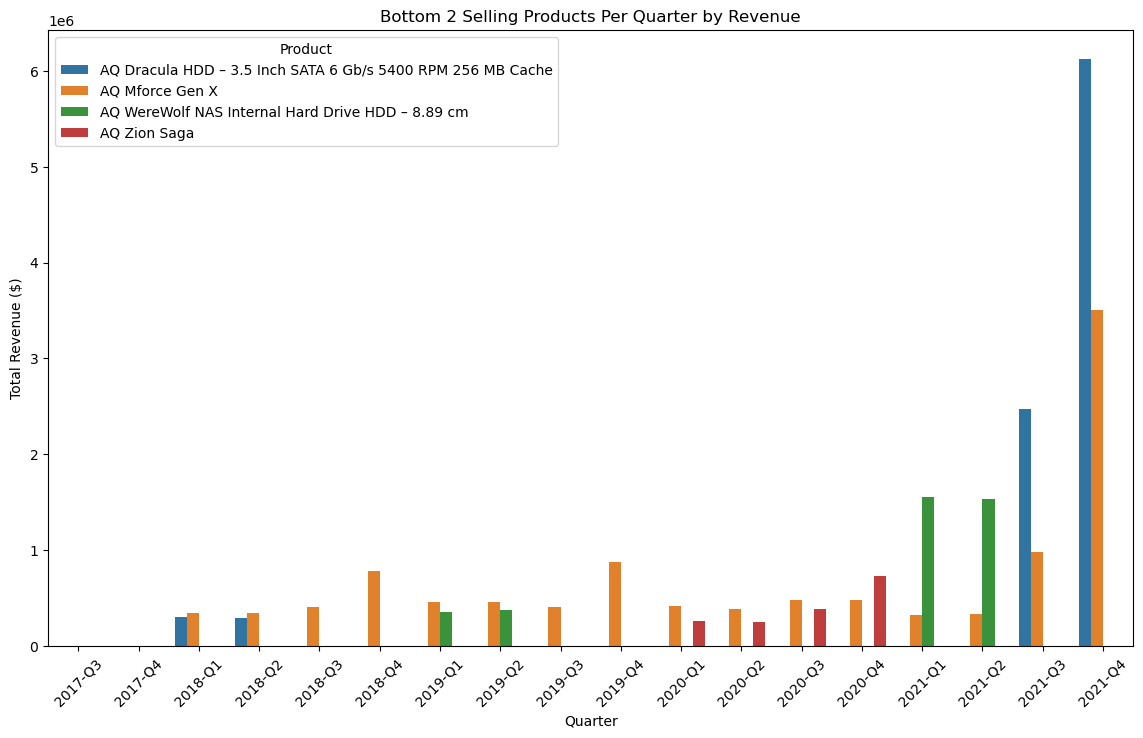

In [294]:

# Connect to the database
con = sqlite3.connect('atliq_db.sqlite3')

# Load the datasets into DataFrames
dim_product = pd.read_sql_query("SELECT * FROM dim_product", con)
fact_sales_monthly = pd.read_sql_query("SELECT * FROM fact_sales_monthly", con)
fact_gross_price = pd.read_sql_query("SELECT * FROM fact_gross_price", con)

# Close the database connection
con.close()

# Ensure the date columns are correctly parsed
fact_sales_monthly['date'] = pd.to_datetime(fact_sales_monthly['date'])
fact_sales_monthly['fiscal_year'] = fact_sales_monthly['date'].dt.year

# Merge fact_sales_monthly with fact_gross_price to get gross price information
merged_sales_price = pd.merge(fact_sales_monthly, fact_gross_price, 
                              how='left', 
                              on=['product_code', 'fiscal_year'])

# Calculate revenue (gross price * sold quantity)
merged_sales_price['revenue'] = merged_sales_price['gross_price'] * merged_sales_price['sold_quantity']

# Merge the result with dim_product to get product names
merged_data = pd.merge(merged_sales_price, dim_product, how='left', left_on='product_code', right_on='product_code')

# Extract month and year from the date
merged_data['month_year'] = merged_data['date'].dt.to_period('M')
merged_data['year'] = merged_data['date'].dt.year
merged_data['quarter'] = merged_data['date'].dt.quarter
merged_data['year_quarter'] = merged_data['year'].astype(str) + '-Q' + merged_data['quarter'].astype(str)

# Aggregate sales data by month
monthly_sales = merged_data.groupby(['month_year', 'product'])['revenue'].sum().reset_index()

# Rank the products by revenue within each month in ascending order
monthly_sales['rank'] = monthly_sales.groupby('month_year')['revenue'].rank(method='first', ascending=True)

# Select the bottom 2 products for each month
bottom2_monthly_sales = monthly_sales[monthly_sales['rank'] <= 2].sort_values(['month_year', 'rank'])

# Convert month_year to string for better visualization
bottom2_monthly_sales['month_year'] = bottom2_monthly_sales['month_year'].astype(str)

# Aggregate sales data by quarter
quarterly_sales = merged_data.groupby(['year_quarter', 'product'])['revenue'].sum().reset_index()

# Rank the products by revenue within each quarter in ascending order
quarterly_sales['rank'] = quarterly_sales.groupby('year_quarter')['revenue'].rank(method='first', ascending=True)

# Select the bottom 2 products for each quarter
bottom2_quarterly_sales = quarterly_sales[quarterly_sales['rank'] <= 2].sort_values(['year_quarter', 'rank'])

# Display the results
display(bottom2_monthly_sales.head(4))
display(bottom2_quarterly_sales.head(4))

# Visualization for monthly bottom sellers by revenue
plt.figure(figsize=(14, 8))
sns.barplot(x='month_year', y='revenue', hue='product', data=bottom2_monthly_sales)
plt.title('Bottom 2 Selling Products Per Month by Revenue')
plt.xlabel('Month')
plt.ylabel('Total Revenue ($)')
plt.legend(title='Product')
plt.xticks(rotation=45)
plt.show()

# Visualization for quarterly bottom sellers by revenue
plt.figure(figsize=(14, 8))
sns.barplot(x='year_quarter', y='revenue', hue='product', data=bottom2_quarterly_sales)
plt.title('Bottom 2 Selling Products Per Quarter by Revenue')
plt.xlabel('Quarter')
plt.ylabel('Total Revenue ($)')
plt.legend(title='Product')
plt.xticks(rotation=45)
plt.show()